<a href="https://colab.research.google.com/github/ollema/nlp2019/blob/master/a1_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install transformers
!wget https://raw.githubusercontent.com/ollema/nlp2019/master/a1_data/wsd_train.txt

--2019-11-12 15:25:24--  https://raw.githubusercontent.com/ollema/nlp2019/master/a1_data/wsd_train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46435645 (44M) [text/plain]
Saving to: ‘wsd_train.txt.3’

wsd_train.txt.3     100%[===================>]  44.28M   177MB/s    in 0.3s    

2019-11-12 15:25:25 (177 MB/s) - ‘wsd_train.txt.3’ saved [46435645/46435645]



In [5]:
import torch
from torch import nn
import time
import torchtext

from collections import defaultdict, OrderedDict
import copy
import random
import sys
random.seed(1)
torch.manual_seed(1)

import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina' 
plt.style.use('seaborn')

from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
model_name = 'distilbert-base-uncased'

tokenizer = DistilBertTokenizer.from_pretrained(model_name)

# A small helper function that will call the BERT tokenizer and truncate.
def bert_tokenize(sen):
    return tokenizer.tokenize(sen)[:138]


def read_data(corpus_file, doc_start, with_padding = True):
    """ Parses input file and returns filtered datasets for each word-type in corpus as well as
    list of word-types found in corpus. """
    # Initialization
    text = torchtext.data.Field(sequential=True, tokenize=bert_tokenize, pad_token=tokenizer.pad_token,
                                init_token=tokenizer.cls_token, eos_token=tokenizer.sep_token)
    label = torchtext.data.LabelField(is_target=True)
    datafields = [('text', text), ('label', label)]
    label_column = 0

    if with_padding == True:
        pad_string = tokenizer.pad_token
        sentence_length = 140
        half_sentence_length = int(sentence_length/2)
        with open(corpus_file, encoding='utf-8') as f:
            examples = []
            for line in f:
                columns = line.strip().split(maxsplit=doc_start)
                position_of_wordtype = int(columns[2])

                # Split the long string doc into array and extract words before the wordtype.
                doc = columns[-1]
                doc_string_vector = doc.split()
                temp_pad = [pad_string for x in range(0,70)]

                padded_doc = []
                padded_doc.extend(temp_pad)
                padded_doc.extend(doc_string_vector)
                padded_doc.extend(temp_pad)

                sliced_doc = padded_doc[position_of_wordtype:position_of_wordtype + 140]

                if len(sliced_doc) != 140:
                    print(sliced_doc)
                    raise RuntimeError

                sliced_doc = " ".join(sliced_doc)
                label = columns[label_column]

                examples.append(torchtext.data.Example.fromlist([sliced_doc, label], datafields))
    else:
        with open(corpus_file, encoding='utf-8') as f:
            examples = []
            for line in f:
                columns = line.strip().split(maxsplit=doc_start)
                doc = columns[-1]
                label = columns[label_column]
                examples.append(torchtext.data.Example.fromlist([doc, label], datafields))
    unfiltered_data = torchtext.data.Dataset(examples, datafields,filter_pred=None)

    # Read complete dataset to get set of word-types. E.i 'keep', 'line'...
    filter_function = None
    word_types = set()
    for example in unfiltered_data.examples:
        word_types.add(example.label.split("%", 1)[0])
    word_types = list(word_types)

    # Create filtered datasets for each word-type
    filtered_datasets = OrderedDict()
    for a_word_type in word_types:
        filter_function = lambda ex: ex.label.split("%", 1)[0] == a_word_type
        text = torchtext.data.Field(sequential=True, tokenize=bert_tokenize, pad_token=tokenizer.pad_token,
                                    init_token=tokenizer.cls_token, eos_token=tokenizer.sep_token)
        label = torchtext.data.LabelField(is_target=True)
        datafields = [('text', text), ('label', label)]

        filtered_data_set = torchtext.data.Dataset(examples, datafields, filter_pred=filter_function)
        filtered_datasets[a_word_type] = (filtered_data_set, text, label)
    return filtered_datasets


def evaluate_validation(scores, gold):
    guesses = scores.argmax(dim=1)
    return (guesses == gold).sum().item()

filtered_datasets = read_data('wsd_train.txt', doc_start=4)

models = OrderedDict()
max_verifications = OrderedDict()
model_vocabs = OrderedDict()
model_label_vocabs = OrderedDict()

for word_type, filtered_dataset in filtered_datasets.items():
    dataset = filtered_dataset[0]
    text = filtered_dataset[1]
    label = filtered_dataset[2]

    train, valid = dataset.split([0.8, 0.2])
    
    text.build_vocab(train)
    model_vocabs[word_type] = text.vocab
    label.build_vocab(train)
    model_label_vocabs[word_type] = label.vocab

    text.vocab.stoi = tokenizer.vocab
    text.vocab.itos = list(tokenizer.vocab)

    device = 'cuda'

    train_iterator = torchtext.data.Iterator(
        train,
        device=device,
        batch_size=32,
        repeat=False,
        train=True,
        sort=False)

    valid_iterator = torchtext.data.Iterator(
        valid,
        device=device,
        batch_size=32,
        repeat=False,
        train=False,
        sort=False)
    
    n_senses = len(label.vocab)

    print(f"Using DistilBertForSequenceClassification")
    model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=n_senses)
    model.cuda()

    no_decay = ['bias', 'LayerNorm.weight']
    decay = 0.01
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': decay},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]

    optimizer = AdamW(optimizer_grouped_parameters, lr=5e-5, eps=1e-8)

    n_epochs = 2

    history = defaultdict(list)
    max_val_acc = -1

    print(f"Training {word_type}...")
    for i in range(n_epochs):
        
        t0 = time.time()
        
        loss_sum = 0
        n_batches = 0

        model.train()
        
        for batch in train_iterator:
            print('.', end='')
            sys.stdout.flush()

            text = batch.text.t()

            optimizer.zero_grad()

            outputs = model(text, labels=batch.label)
                        
            loss = outputs[0]
            
            loss.backward()
            optimizer.step()
                        
            loss_sum += loss.item()
            n_batches += 1
        
        train_loss = loss_sum / n_batches
        history['train_loss'].append(train_loss)
        
        n_correct = 0
        n_valid = len(valid)
        loss_sum = 0
        n_batches = 0

        model.eval()
        
        for batch in valid_iterator:
            print('.', end='')
            sys.stdout.flush()
            
            text = batch.text.t()
            
            with torch.no_grad():
                outputs = model(text, labels=batch.label)
                loss_batch, scores = outputs
                
            loss_sum += loss_batch.item()
            n_correct += evaluate_validation(scores, batch.label)
            n_batches += 1
            
            if n_batches % 50 == 0:
                print()

        val_acc = n_correct / n_valid
        val_loss = loss_sum / n_batches

        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)   

        if val_acc > max_val_acc:
            max_val_acc = val_acc
            models[word_type] = copy.deepcopy(model)
            max_verifications[word_type] = max_val_acc   
                
        t1 = time.time()
        print()
        print(f'Epoch {i+1}: train loss = {train_loss:.4f}, val loss = {val_loss:.4f}, val acc: {val_acc:.4f}, time = {t1-t0:.4f}')

    break

    plt.plot(history['train_loss'])
    plt.plot(history['val_loss'])
    plt.plot(history['val_acc'])
    plt.legend(['training loss', 'validation loss', 'validation accuracy'])
    plt.show()


Using DistilBertForSequenceClassification
Training line...
..............................................................................................................................................................................
Epoch 1: train loss = 0.5219, val loss = 0.2520, val acc: 0.9243, time = 125.6764
..............................................................................................................................................................................
Epoch 2: train loss = 0.1529, val loss = 0.1173, val acc: 0.9657, time = 124.9546


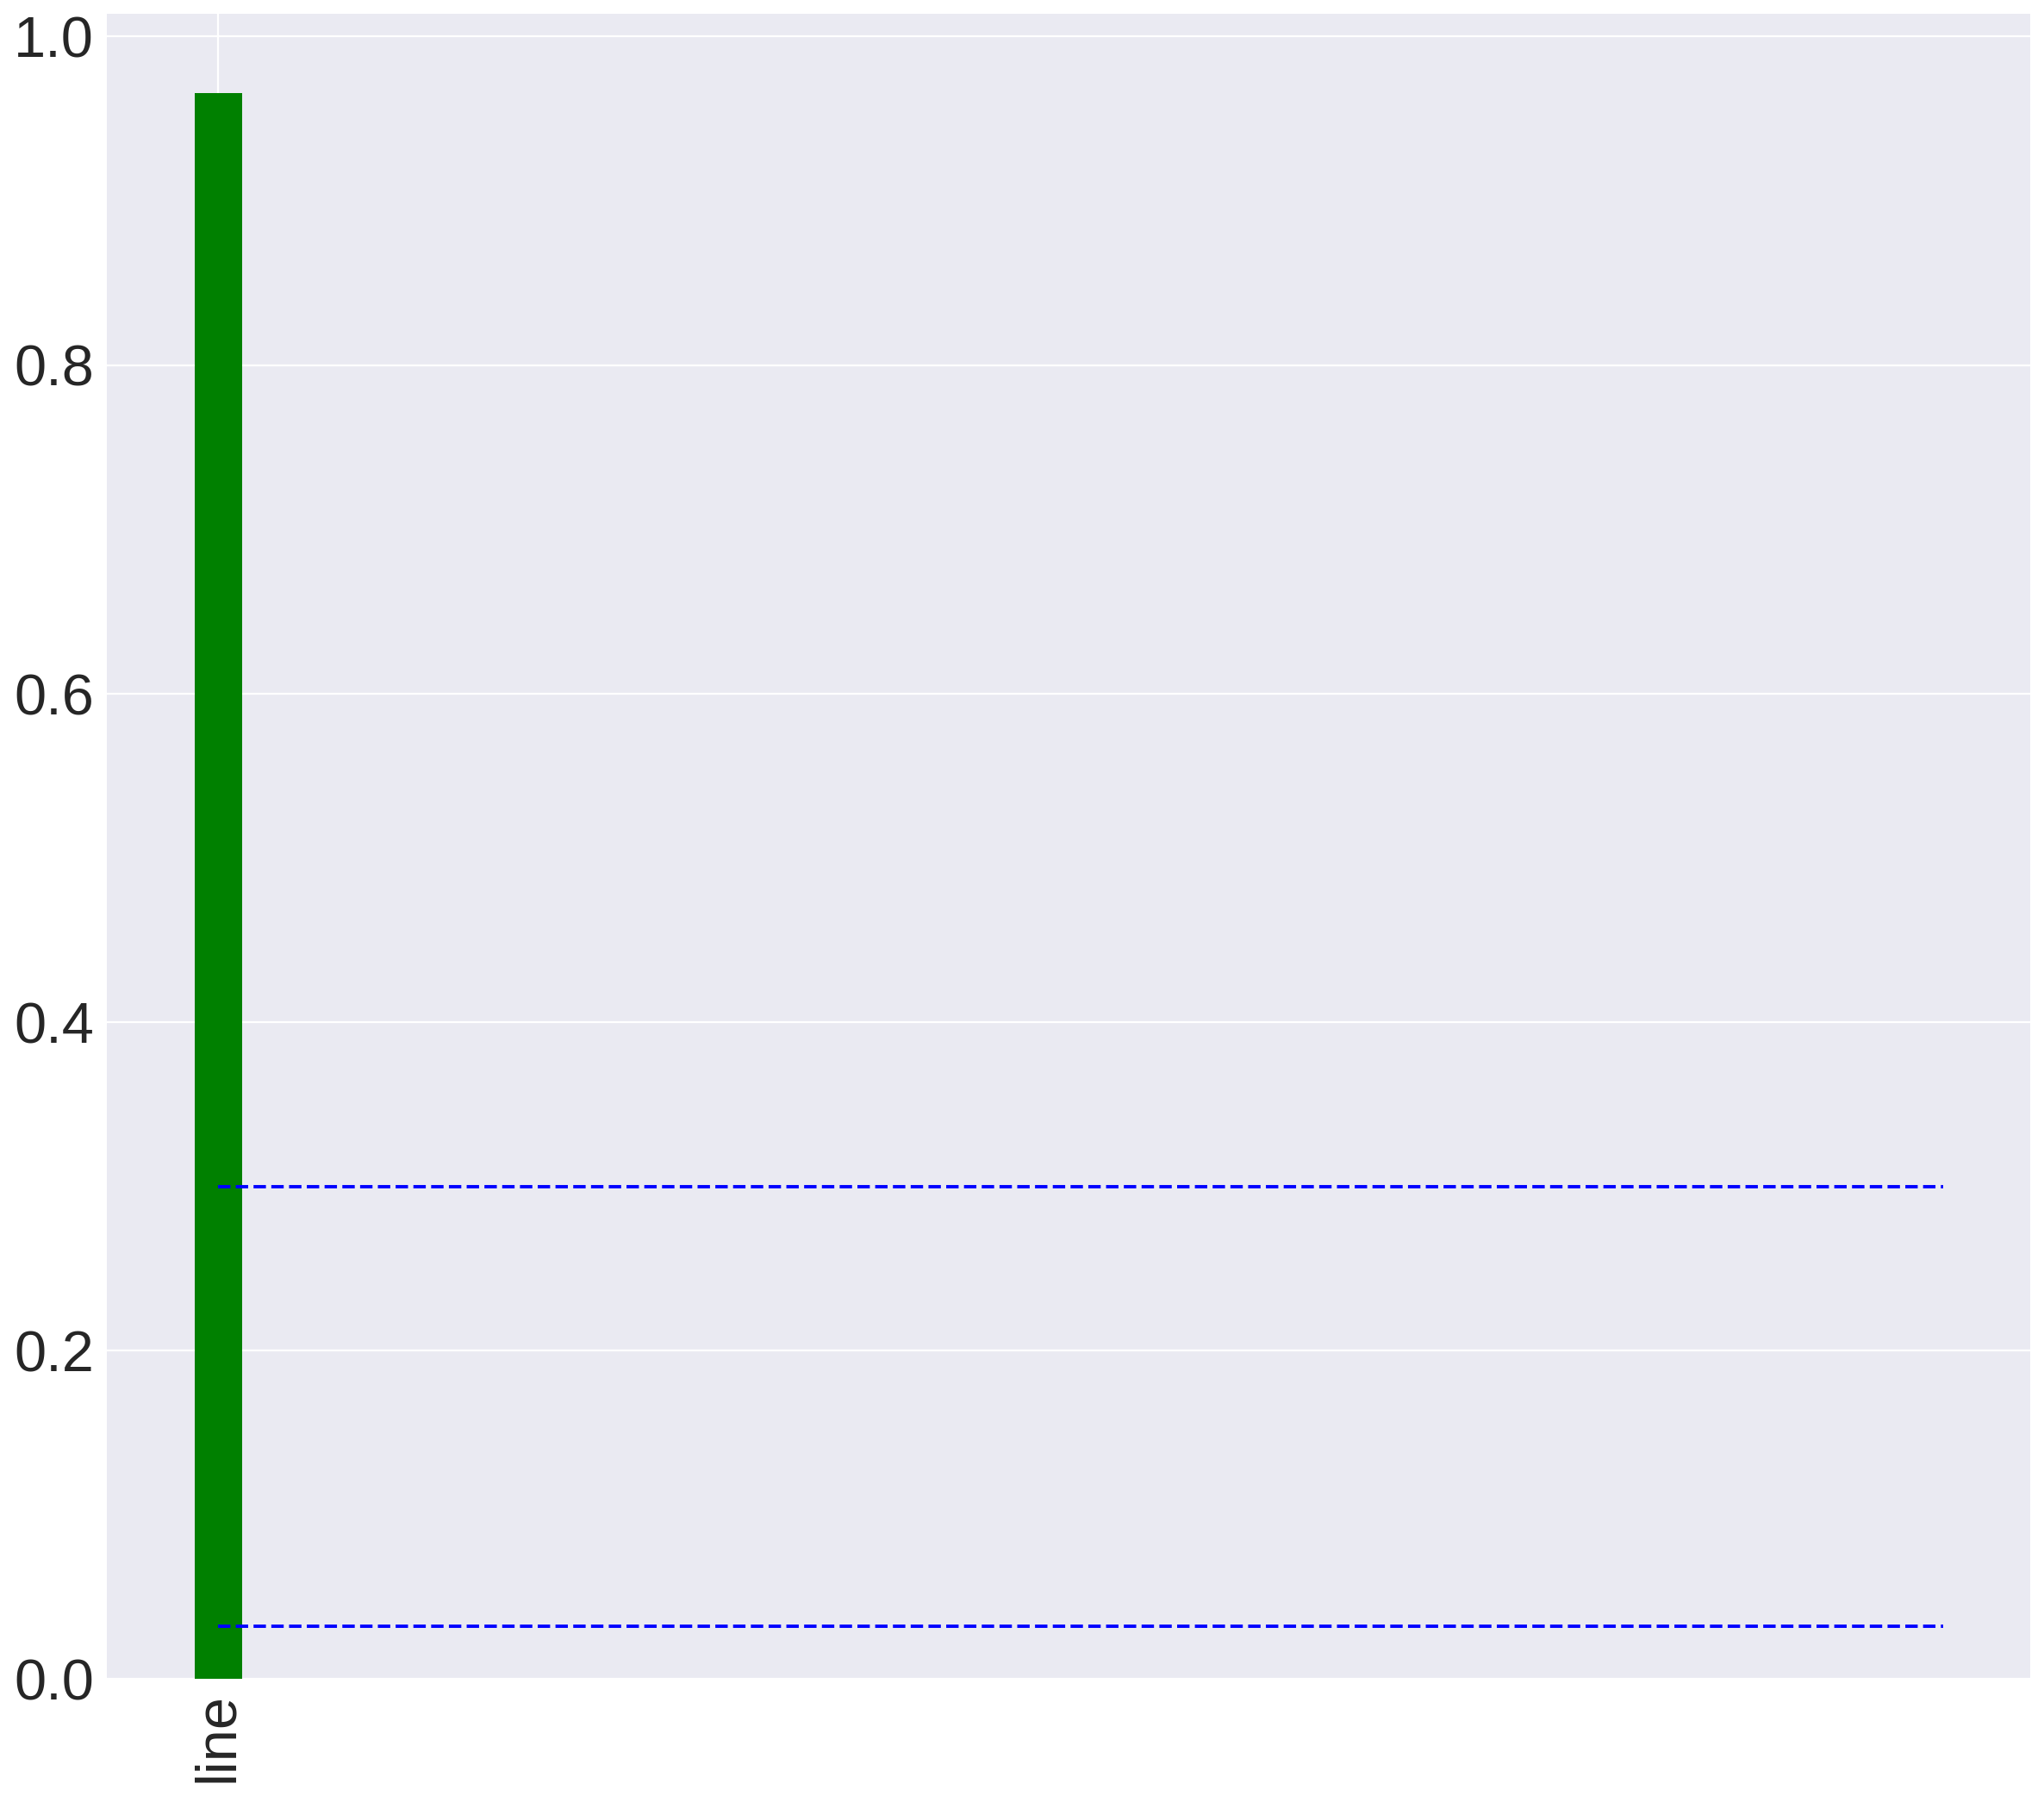

In [6]:
avg = sum(max_verifications.values())/30

fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.bar(list(max_verifications.keys()), max_verifications.values(), color='g')
x = [i for i in range(0,30)]
y = [0.3 for i in range(0,30)]
plt.plot(x,y,'b--')
x = [i for i in range(0,30)]
y = [avg for i in range(0,30)]
plt.plot(x,y,'b--')
plt.tick_params(axis='both', which='major', labelsize=30) 
plt.xticks(rotation='vertical')
plt.show()

In [7]:
!wget https://raw.githubusercontent.com/peterSvenningsson/NLP_documents_/master/wsd_test_blind.txt

--2019-11-12 15:32:25--  https://raw.githubusercontent.com/peterSvenningsson/NLP_documents_/master/wsd_test_blind.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7987686 (7.6M) [text/plain]
Saving to: ‘wsd_test_blind.txt.3’

wsd_test_blind.txt. 100%[===================>]   7.62M  --.-KB/s    in 0.1s    

2019-11-12 15:32:26 (79.7 MB/s) - ‘wsd_test_blind.txt.3’ saved [7987686/7987686]



In [0]:
def read_test_data(corpus_file, doc_start):
    TEXT = torchtext.data.Field(sequential=True, tokenize=lambda x: x.split())
    WORDTYPE = torchtext.data.Field()
    datafields = [('text', TEXT), ('wordtype', WORDTYPE)]
    pad_string = '<pad>'
    sentence_length = 140
    half_sentence_length = int(sentence_length/2)
    with open(corpus_file, encoding='utf-8') as f:
        examples = []
        for line in f:
            columns = line.strip().split(maxsplit=doc_start)
            position_of_wordtype = int(columns[2])

            # Split the long string doc into array and extract words before the wordtype.
            doc = columns[-1]
            doc_string_vector = doc.split()
            temp_pad = [pad_string for x in range(0,70)]

            padded_doc = []
            padded_doc.extend(temp_pad)
            padded_doc.extend(doc_string_vector)
            padded_doc.extend(temp_pad)

            sliced_doc = padded_doc[position_of_wordtype:position_of_wordtype + 140]

            if len(sliced_doc) != 140:
                print(sliced_doc)
                raise RuntimeError

            sliced_doc = " ".join(sliced_doc)

            wordtype = columns[1].split('.')[0]
            examples.append(torchtext.data.Example.fromlist([sliced_doc, wordtype], datafields))
    dataset = torchtext.data.Dataset(examples, datafields)
    return (dataset, TEXT, WORDTYPE)

    

In [10]:
test_dataset = read_test_data('wsd_test_blind.txt', doc_start=4)
for example in test_dataset[0].examples:
    test_example_string = example.text
    example_wordtype = example.wordtype[0]

    if example_wordtype != "line":
        continue

    # Load vocabs
    example_vocab = model_vocabs[example_wordtype]
    example_label_vocabs = model_label_vocabs[example_wordtype]

    # Encode string
    # encoded_example = torch.tensor([example_vocab.stoi[x] for x in test_example_string],device=device, requires_grad = False)    
    encoded_example_list = []
    for x in test_example_string:
        try:
            i = example_vocab.stoi[x]
        except:
            i = tokenizer.unk_token
        encoded_example_list.append(i)
    encoded_example = torch.tensor(encoded_example_list, device=device, requires_grad=False)

    # Load correct model
    model = models[example_wordtype]

    # Get prediction
    scores = model(encoded_example.unsqueeze(1))
    prediction = scores.argmax(dim=1)

    # Decode prediction
    decoded_prediction = example_label_vocabs.itos[prediction]
    print(decoded_prediction)




ValueError: ignored